# Load packages

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import os

from os import path
from tensorflow.keras.utils import image_dataset_from_directory
from matplotlib import pyplot as plt
from tensorflow.keras import layers, losses, optimizers, metrics, callbacks, Model
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input

In [2]:
tf.config.list_logical_devices()

[LogicalDevice(name='/device:CPU:0', device_type='CPU'),
 LogicalDevice(name='/device:GPU:0', device_type='GPU')]

In [3]:
tf.__version__

'2.10.1'

In [4]:
SEED = 123
N_CLASS = 10
IMG_SIZE = 224

# Load data

In [5]:
labels_df = pd.read_csv(path.join(os.getcwd(), 'cifar-10', 'trainLabels.csv'))
labels_df.label = pd.Categorical(labels_df.label)
labels_df['codes'] = labels_df.label.cat.codes
labels_df['name'] = labels_df['id'].astype(str) + ".png"
labels_df.sort_values(by="name")
labels_df

,id,label,codes,name
0,1,frog,6,1.png
1,2,truck,9,2.png
2,3,truck,9,3.png
3,4,deer,4,4.png
4,5,automobile,1,5.png
...,...,...,...,...
49995,49996,bird,2,49996.png
49996,49997,frog,6,49997.png
49997,49998,truck,9,49998.png
49998,49999,automobile,1,49999.png


In [6]:
filenames = list(os.walk(path.join(os.getcwd(), 'cifar-10', 'train', 'train_images'), topdown=False))[0][2]
filenames = pd.DataFrame(filenames, columns=["name"])
filenames = filenames.merge(labels_df, on="name")
filenames

,name,id,label,codes
0,1.png,1,frog,6
1,10.png,10,cat,3
2,100.png,100,automobile,1
3,1000.png,1000,dog,5
4,10000.png,10000,dog,5
...,...,...,...,...
49995,9995.png,9995,frog,6
49996,9996.png,9996,cat,3
49997,9997.png,9997,truck,9
49998,9998.png,9998,automobile,1


In [7]:
dataset_train, dataset_val = image_dataset_from_directory(
    directory=path.join(os.getcwd(), 'cifar-10', 'train'),
    labels=list(filenames['codes']),
    label_mode='int',
    validation_split=0.2,
    shuffle=True,
    subset='both',
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=512,
    seed=SEED
)
dataset_train = dataset_train.map(lambda x, y : (x, tf.one_hot(y, N_CLASS)))
dataset_val = dataset_val.map(lambda x, y : (x, tf.one_hot(y, N_CLASS)))

Found 50000 files belonging to 1 classes.
Using 40000 files for training.
Using 10000 files for validation.


In [8]:
X, y = next(iter(dataset_train))
X.shape, y.shape

(TensorShape([512, 224, 224, 3]), TensorShape([512, 10]))

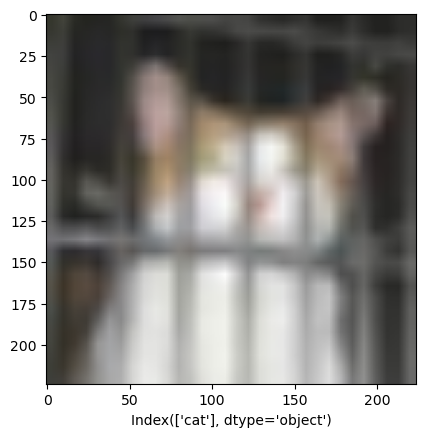

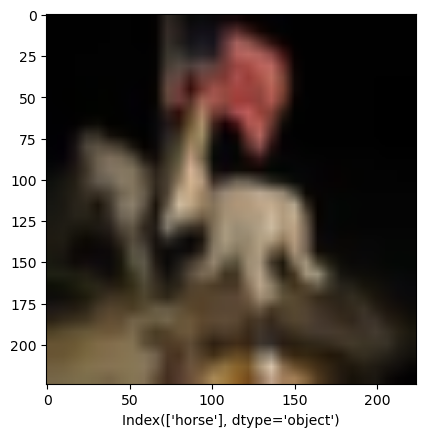

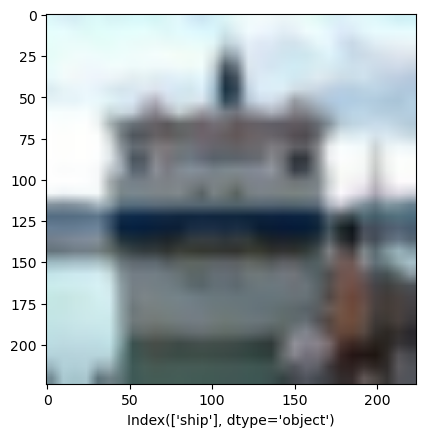

In [9]:
for i in range(3):
    plt.imshow(X[i].numpy().astype(int))
    plt.xlabel(filenames.label.cat.categories[np.argwhere(y[i].numpy()).flatten()])
    plt.show()

# ResNet - initialization

In [10]:
os.makedirs("weights", exist_ok=True)

In [11]:
resnet = ResNet50(include_top=False, input_shape=(224, 224, 3), weights='imagenet')
resnet.trainable = False
x = layers.GlobalAveragePooling2D()(resnet.output)
output = layers.Dense(10, activation="softmax")(x)

model = Model(inputs=resnet.inputs, outputs=output)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [12]:
dataset_train = dataset_train.map(lambda x, y : (preprocess_input(x), y))
dataset_val = dataset_val.map(lambda x, y : (preprocess_input(x), y))

In [13]:
model.compile(
    optimizer=optimizers.Adam(learning_rate=0.1),
    loss=losses.CategoricalCrossentropy(),
    metrics=[metrics.CategoricalAccuracy()]
)

checkpoint = callbacks.ModelCheckpoint(
    filepath="weigths/resnet.h5",
    monitor="val_loss",
    verbose=0,
    save_best_only=True,
    save_weights_only=True
)

early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=5,
    verbose=0,
    mode='auto',
    baseline=None,
    restore_best_weights=True
)

reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=0.0001, verbose=1)

# ResNet - training

In [14]:
history = model.fit(
    dataset_train,
    epochs=100,
    validation_data=dataset_val,
    shuffle=True,
    callbacks=[checkpoint, early_stopping, reduce_lr]
)

Epoch 1/100
79/79 [==============================] - 65s 667ms/step - loss: 14.0258 - categorical_accuracy: 0.7504 - val_loss: 2.6880 - val_categorical_accuracy: 0.8744 - lr: 0.1000
Epoch 2/100
79/79 [==============================] - 58s 670ms/step - loss: 1.7467 - categorical_accuracy: 0.8963 - val_loss: 2.2561 - val_categorical_accuracy: 0.8543 - lr: 0.1000
Epoch 3/100
79/79 [==============================] - 57s 656ms/step - loss: 1.1277 - categorical_accuracy: 0.9024 - val_loss: 1.3695 - val_categorical_accuracy: 0.8860 - lr: 0.1000
Epoch 4/100
79/79 [==============================] - 57s 662ms/step - loss: 1.0765 - categorical_accuracy: 0.8980 - val_loss: 2.2356 - val_categorical_accuracy: 0.8407 - lr: 0.1000
Epoch 5/100
79/79 [==============================] - 56s 647ms/step - loss: 1.0173 - categorical_accuracy: 0.9046 - val_loss: 1.8754 - val_categorical_accuracy: 0.8681 - lr: 0.1000
Epoch 6/100
79/79 [==============================] - ETA: 0s - loss: 0.8511 - categorical_accu

# ResNet - scores

In [15]:
history

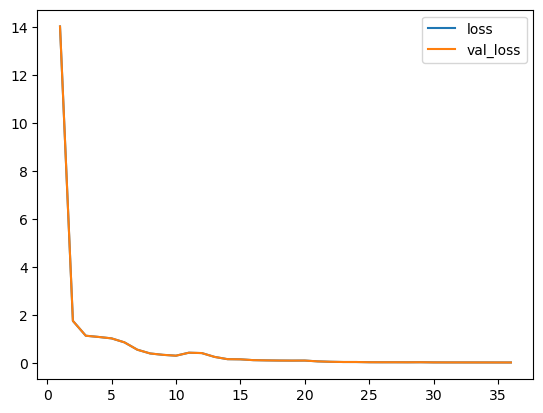

In [19]:
loss = history.history['loss']
val_loss = history.history['val_loss']
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']
plt.figure()
plt.plot(range(1, 37), loss, label="loss")
plt.plot(range(1, 37), loss, label="val_loss")
plt.legend()
plt.title("Categorical crossentropy")
plt.show()

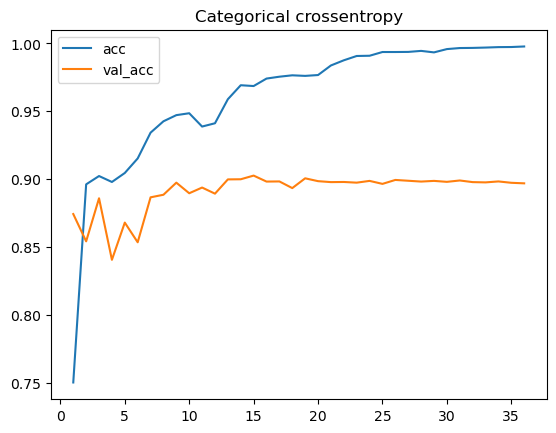

In [20]:
plt.figure()
plt.plot(range(1, 37), acc, label="acc")
plt.plot(range(1, 37), val_acc, label="val_acc")
plt.legend()
plt.title("Categorical crossentropy")
plt.show()